Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 10 - Monte Carlo Simulations in Finance

## 10.1 Simulating stock price dynamics using geometric Brownian motion

### How to do it...

1. Import the libraries:

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf

2. Download data from Yahoo Finance:

In [4]:
df = yf.download("IBM", 
                 start="2021-01-01", 
                 end="2022-01-31")

[*********************100%%**********************]  1 of 1 completed


3. Calculate and plot daily returns:

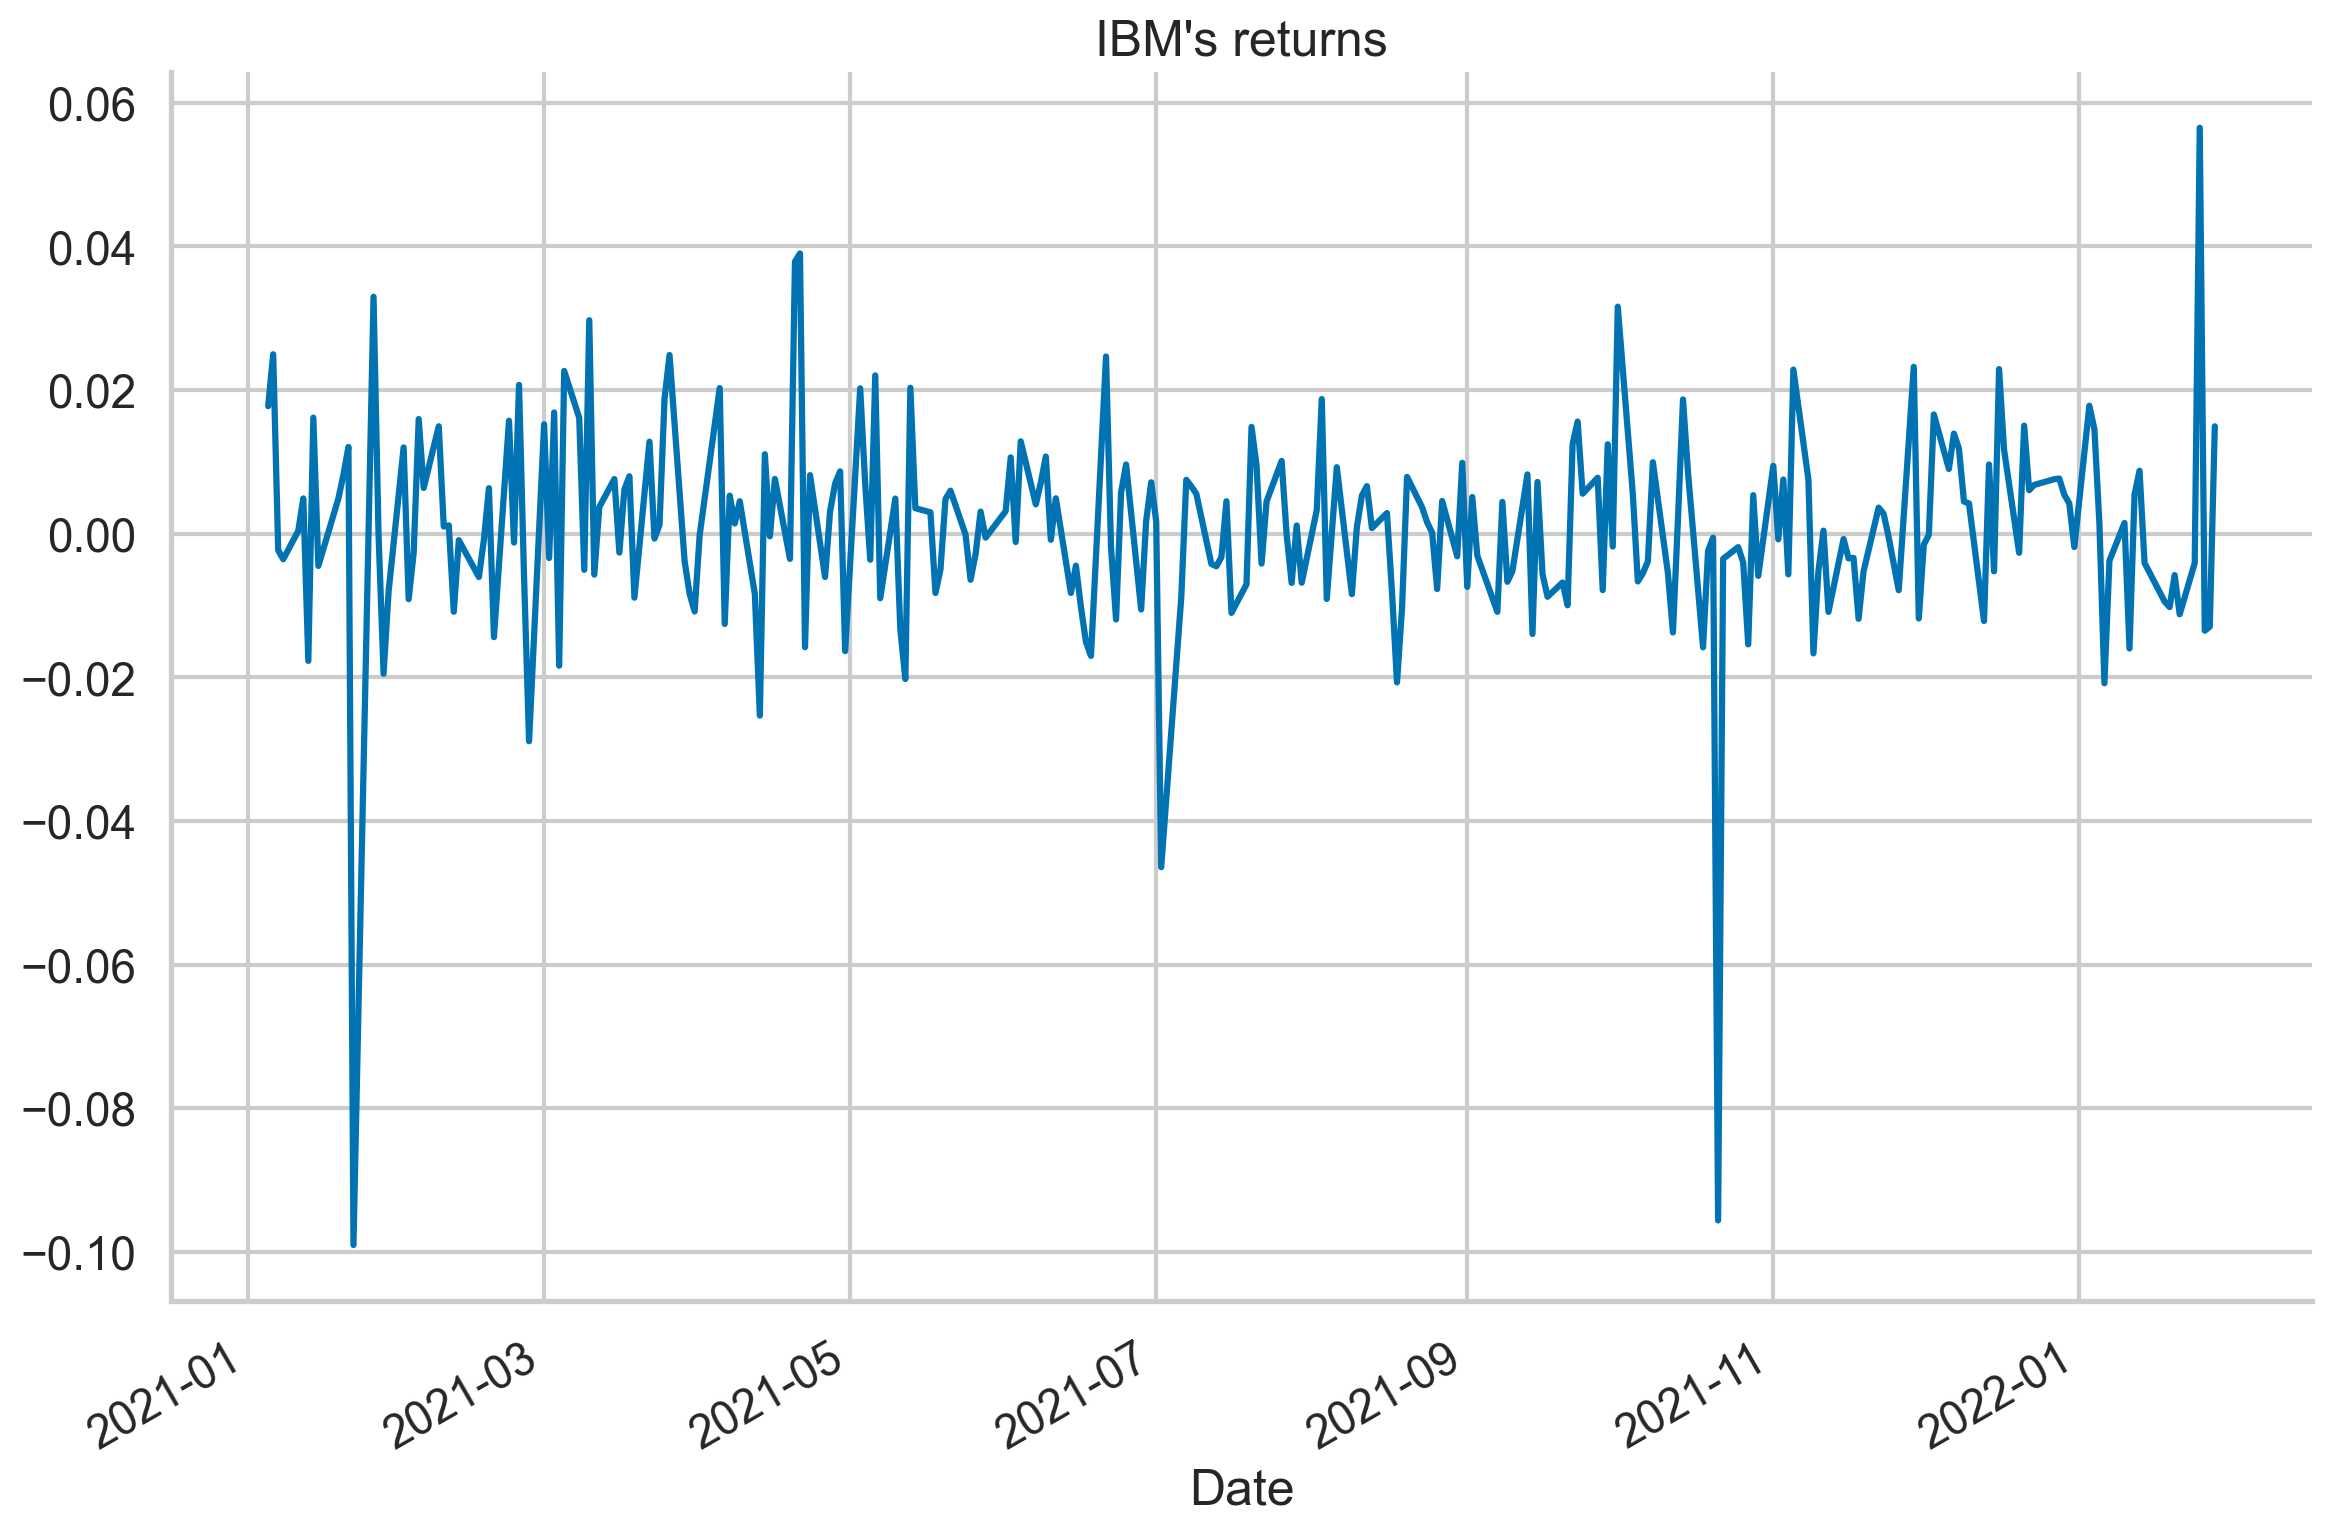

In [5]:
returns = df["Adj Close"].pct_change().dropna()
returns.plot(title="IBM's returns")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_1", dpi=200)

In [6]:
print(f"Average return: {100 * returns.mean():.2f}%")

Average return: 0.08%


4. Split data into the training and test sets:

In [7]:
train = returns["2021"]
test = returns["2022"]

5. Specify the parameters of the simulation:

In [8]:
T = len(test)
N = len(test)
S_0 = df.loc[train.index[-1], "Adj Close"]
N_SIM = 100
mu = train.mean()
sigma = train.std()

6. Define the function used for simulations:

In [9]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42):
    """
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    """
    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

7. Run the simulations and store the results in a DataFrame:

In [10]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

sim_df = pd.DataFrame(np.transpose(gbm_simulations), 
                      index=train.index[-1:].union(test.index))

8. Create a DataFrame with the average value for each time step and the corresponding actual stock price:

In [11]:
res_df = sim_df.mean(axis=1).to_frame()
res_df = res_df.join(df["Adj Close"])
res_df.columns = ["simulation_average", "adj_close_price"]
res_df.head()

,simulation_average,adj_close_price
Date,,
2021-12-31,120.223015,120.223015
2022-01-03,120.466648,122.363739
2022-01-04,120.665598,124.144714
2022-01-05,120.761619,124.324593
2022-01-06,121.114324,121.734131


9. Plot the results of the simulation:

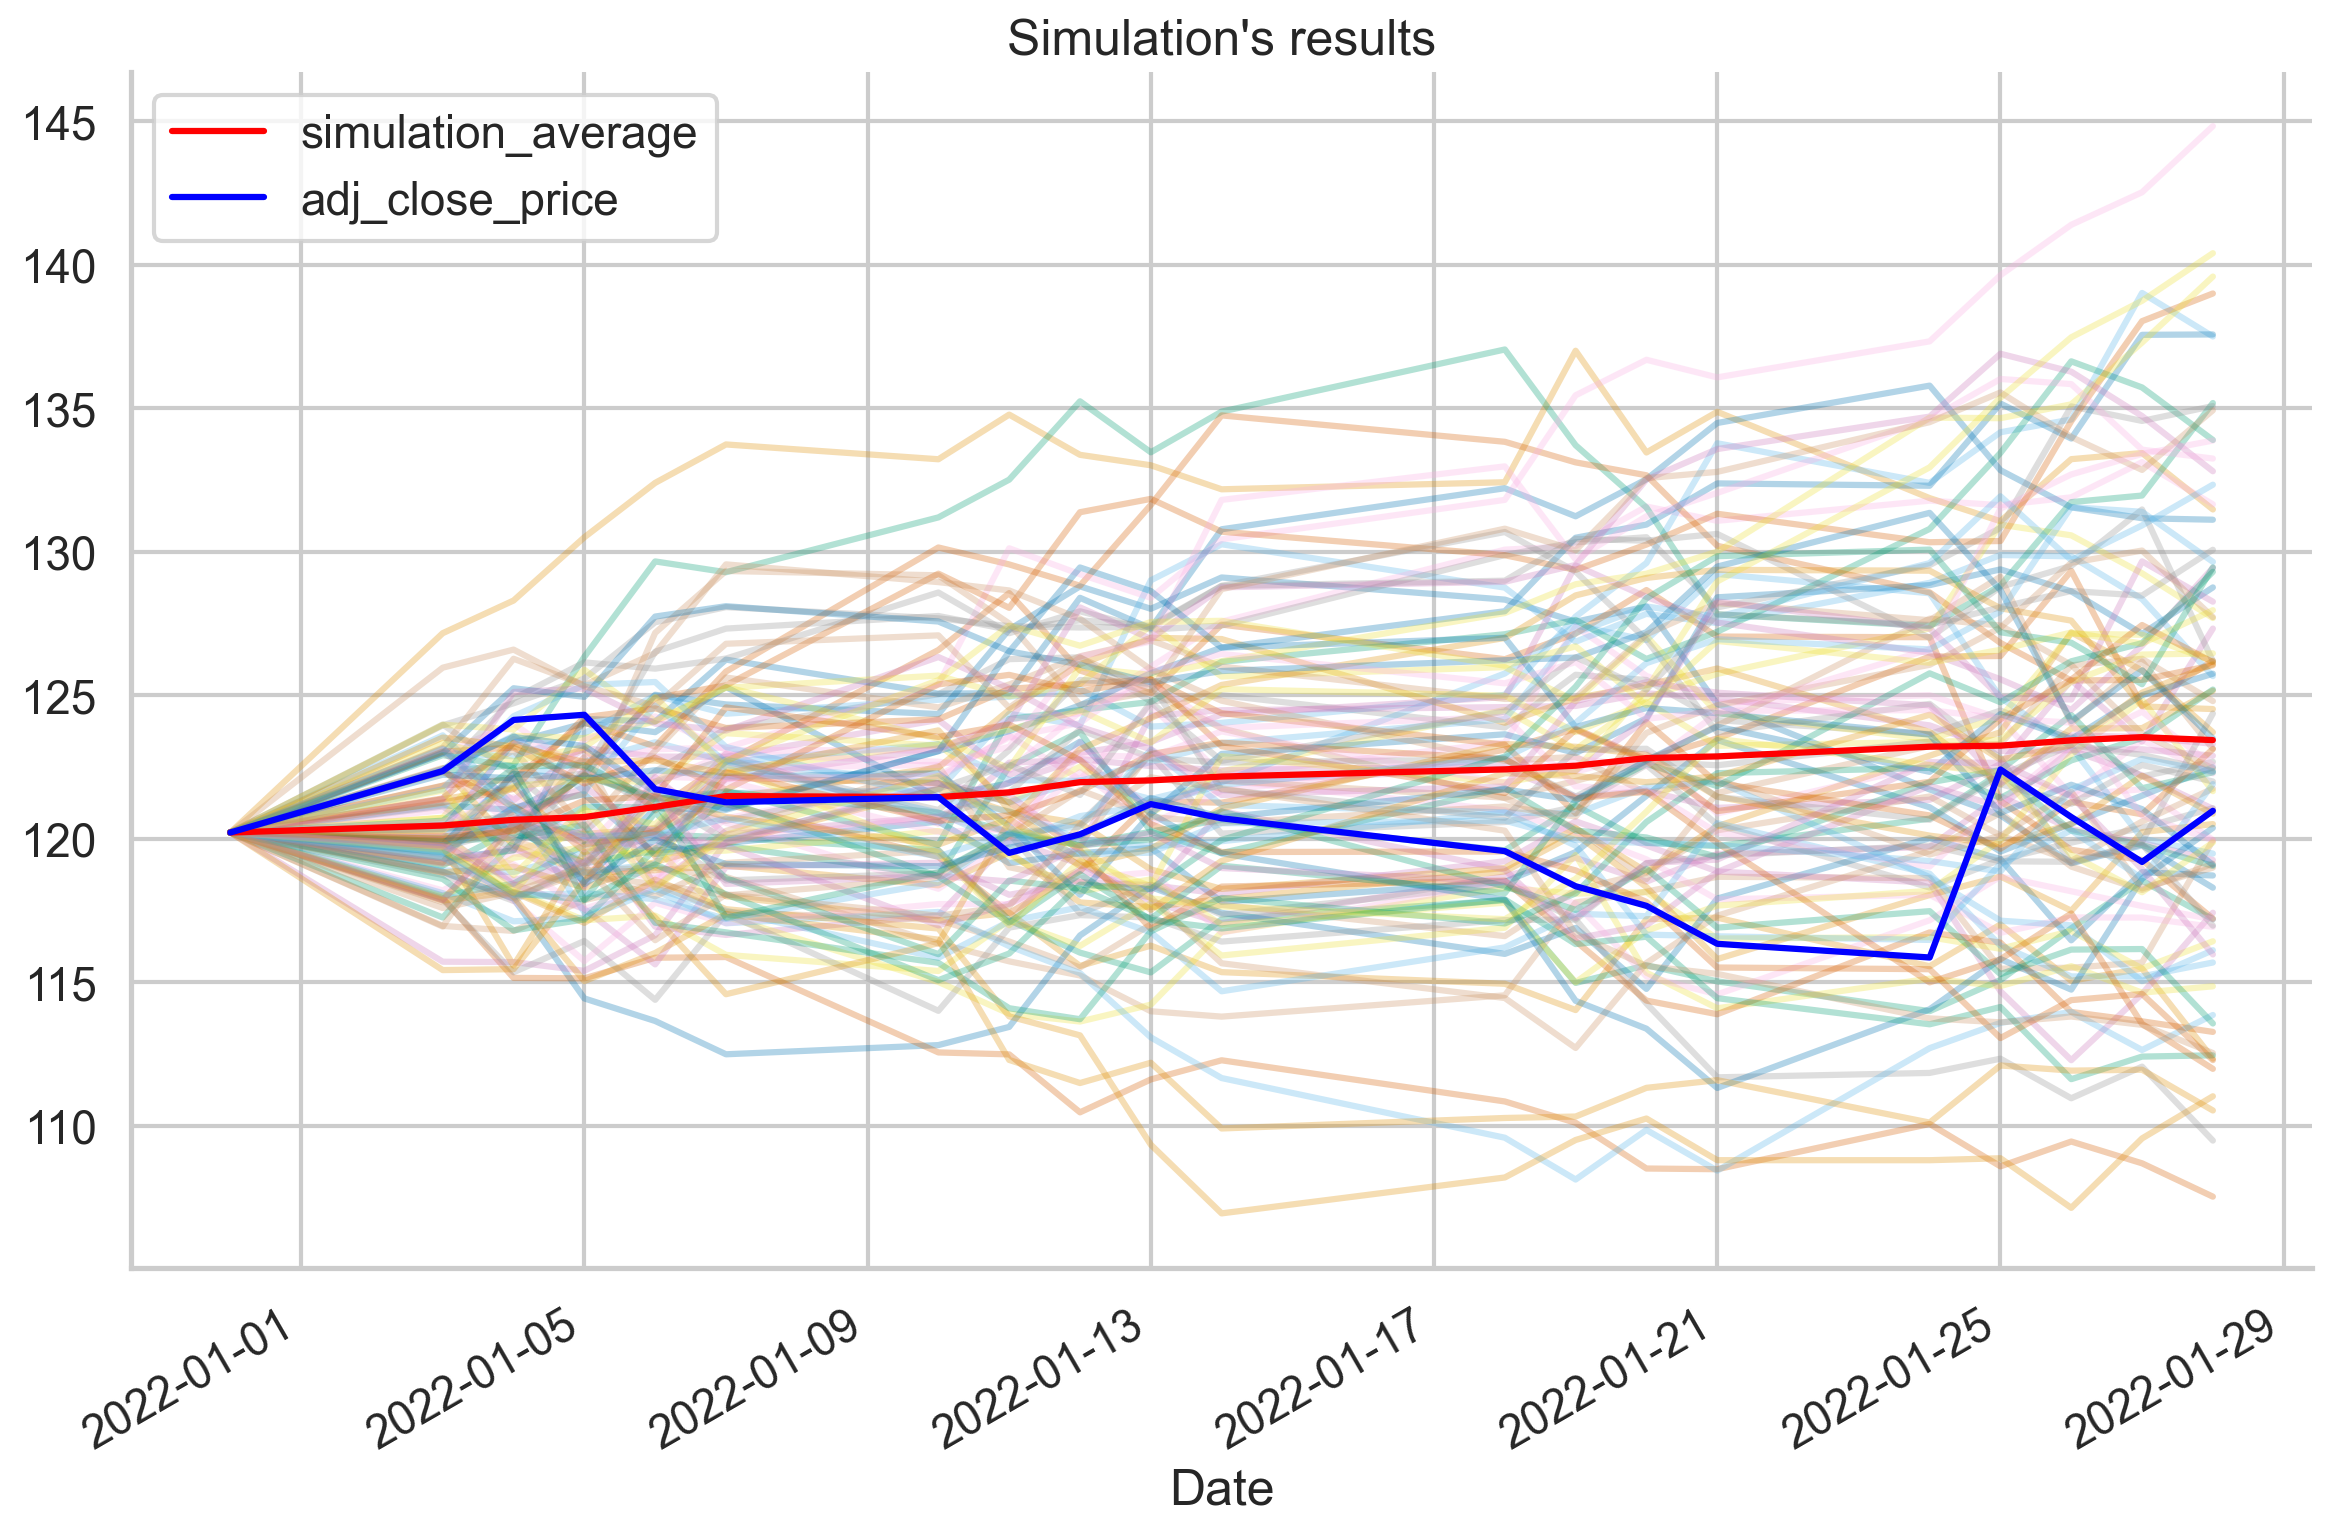

In [12]:
ax = sim_df.plot(
    alpha=0.3, 
    legend=False, 
    title="Simulation's results"
)
res_df.plot(ax=ax, color = ["red", "blue"])

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_2", dpi=200)

### There's more 

In [13]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

190 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, 
                 antithetic_var=False):
    """
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    """
    
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [15]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

105 µs ± 21.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

96.3 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## 10.2 Pricing European options using simulations 

### How to do it...

1. Import the libraries:

In [17]:
import numpy as np
from scipy.stats import norm
from chapter_10_utils import simulate_gbm

2. Define the parameters for the valuation:

In [18]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1_000_000 # number of simulations 
discount_factor = np.exp(-r * T)

3. Define the valuation function using the analytical solution:

In [19]:
def black_scholes_analytical(S_0, K, T, r, sigma, type="call"):
    """
    Function used for calculating the price of European options using the
    analytical form of the Black-Scholes model.

    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Can be one of the following: ["call", "put"]

    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    """

    d1 = (
        np.log(S_0/K) + (r+0.5*sigma**2) * T) / (sigma*np.sqrt(T)
    )
    d2 = d1 - sigma * np.sqrt(T)
    if type == "call":
        N_d1 = norm.cdf(d1, 0, 1)
        N_d2 = norm.cdf(d2, 0, 1)
        val = S_0 * N_d1 - K * np.exp(-r * T) * N_d2
    elif type == "put":
        N_d1 = norm.cdf(-d1, 0, 1)
        N_d2 = norm.cdf(-d2, 0, 1)
        val = K * np.exp(-r * T) * N_d2 - S_0 * N_d1
    else:
        raise ValueError("Wrong input for type!")

    return val


4. Valuate the call option using the specified parameters:

In [20]:
black_scholes_analytical(S_0=S_0, K=K, T=T, 
                         r=r, sigma=sigma, 
                         type="call")

21.79260421286685

5. Simulate the stock path using the `simulate_gbm`  function: 

In [21]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                        n_sims=N_SIMS, T=T, N=N)

6. Calculate the option's premium:

In [22]:
premium = (
    discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
)
premium

21.756178586245806

### There's more

1. Calculate the option premium for the European put option using the analytical formula:

In [23]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type="put")

16.915546662938254

2. Define the modified simulation function, which only looks at the terminal values of the simulation paths:

In [24]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, 
                               type="call", random_seed=42):
    """
    Function used for calculating the price of European options using Monte Carlo simulations.
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of paths to simulate
    type : str
        Type of the option. Can be one of the following: ["call", "put"]
    random_seed : int
        Random seed for reproducibility
        
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using Monte Carlo simulations
    """
    np.random.seed(random_seed)
    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    if type == "call":
        payoff = np.maximum(0, S_T - K)
    elif type == "put":
        payoff = np.maximum(0, K - S_T)
    else: 
        raise ValueError("Wrong input for type!")
        
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

3. Run the simulations for the European put option:

In [25]:
european_option_simulation(S_0, K, T, r, sigma, N_SIMS, type="put")

16.948225203893127

## 10.3 Pricing American options with Least Squares Monte Carlo

### How to do it...

1. Import the libraries:

In [26]:
import numpy as np
from chapter_10_utils import (simulate_gbm, 
                              black_scholes_analytical, 
                              lsmc_american_option)

2. Define the parameters:

In [27]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50 
dt = T / N 
N_SIMS = 10 ** 5 
discount_factor = np.exp(-r * dt)
OPTION_TYPE = "put"
POLY_DEGREE = 5 

3. Simulate the stock prices using GBM:

In [28]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, 
                        T=T, N=N)

4. Calculate the payoff matrix:

In [29]:
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))

5. Define the value matrix and fill in the last column (time T):

In [30]:
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

6. Iteratively calculate the continuation value and the value vector in the given time:

In [31]:
for t in range(N - 1, 0 , -1):
    regression = np.polyfit(gbm_sims[:, t], 
                            value_matrix[:, t + 1] * discount_factor, 
                            POLY_DEGREE)
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor
    )

7. Calculate the option's premium:

In [32]:
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
option_premium

4.464758780741195

8. Calculate the premium of a European put with the same parameters:

In [33]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, 
                         type="put")

3.84430779159684

9. As an extra check, calculate the prices of the American and European call options:

In [34]:
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, 
                                               r=r, sigma=sigma)
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, N=N, r=r, 
                                           sigma=sigma, n_sims=N_SIMS, 
                                           option_type="call", 
                                           poly_degree=POLY_DEGREE)
print(f"European call's price: {european_call_price:.3f}")
print(f"American call's price: {american_call_price:.3f}")

European call's price: 2.174
American call's price: 2.097


## 10.4 Pricing American options using Quantlib

### Getting ready

This setup is the same as Step 2 in the previous recipe.

In [35]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
N = 50
N_SIMS = 10 ** 5 
OPTION_TYPE = "put"
POLY_DEGREE = 5 

### How to do it...

1. Import the library:

In [36]:
import QuantLib as ql

2. Specify the calendar and the day counting convention:

In [37]:
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_counter = ql.ActualActual(ql.ActualActual.ISDA)

3. Specify the valuation date and the expiry date of the option:

In [38]:
valuation_date = ql.Date(1, 1, 2020)
expiry_date =  ql.Date(1, 1, 2021)
ql.Settings.instance().evaluationDate = valuation_date

In [39]:
T = day_counter.yearFraction(valuation_date, expiry_date)
print(f'Time to expiry in years: {T}') 

Time to expiry in years: 1.0


4. Define the option type (call/put), type of exercise and the payoff:

In [40]:
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put
        
exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

In [41]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

In [42]:
# volatility = ql.BlackConstantVol(valuation_date, calendar, sigma, day_counter)
# risk_free_rate = ql.FlatForward(valuation_date, r, day_counter)
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

7. Plug in the market-related data into the BS process:

In [43]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

8. Instantiate the Monte Carlo engine for the American options:

In [44]:
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                             polynomOrder=POLY_DEGREE, 
                             seedCalibration=42, 
                             requiredSamples=N_SIMS)

9. Instantiate the `option` object and set its pricing engine:

In [45]:
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

10. Calculate the option's premium:

In [46]:
option_premium_ql = option.NPV()
option_premium_ql

4.440132892249705

In [47]:
print(f'The value of the American {OPTION_TYPE} option is: {option_premium_ql:.3f}')

The value of the American put option is: 4.440


### There's more

In [48]:
u_0 = u.value() # original value
h = 0.01

u.setValue(u_0 + h)
P_plus_h = option.NPV()

u.setValue(u_0 - h)
P_minus_h = option.NPV()

u.setValue(u_0) # set back to the original value

delta = (P_plus_h - P_minus_h) / (2 * h)

print(f'Delta of the option: {delta:.2f}')

Delta of the option: -1.30


## 10.5 Pricing barrier options

### How to do it...

1. Import the libraries:

In [49]:
import numpy as np
from chapter_10_utils import simulate_gbm

2. Define the parameters for the valuation:

In [50]:
S_0 = 55
K = 60
BARRIER = 65 
r = 0.06
sigma = 0.2
T = 1 
N = 252 
dt = T / N 
N_SIMS = 10 ** 5
OPTION_TYPE = "call"
discount_factor = np.exp(-r * T)

3. Simulate the stock path using the `simulate_gbm`  function: 

In [51]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                        n_sims=N_SIMS, T=T, N=N)

4. Calculate the maximum value per path:

In [52]:
max_value_per_path = np.max(gbm_sims, axis=1)

5. Calculate the payoff:

In [53]:
payoff = np.where(max_value_per_path > BARRIER, 
                  np.maximum(0, gbm_sims[:, -1] - K), 
                  0)

6. Calculate the option's premium:

In [54]:
premium = discount_factor * np.mean(payoff)
premium

3.6267400613568657

### There's more

1. Import the library:

In [55]:
import QuantLib as ql

2. Specify the calendar and the day counting convention:

In [56]:
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
day_counter = ql.ActualActual(ql.ActualActual.ISDA)

3. Specify the valuation date and the expiry date of the option:

In [57]:
valuation_date = ql.Date(1, 1, 2020)
expiry_date =  ql.Date(1, 1, 2021)
ql.Settings.instance().evaluationDate = valuation_date

In [58]:
T = day_counter.yearFraction(valuation_date, expiry_date)
print(f'Time to expiry in years: {T}') 

Time to expiry in years: 1.0


4. Define the option type (call/put), type of exercise and the payoff:

In [59]:
if OPTION_TYPE == "call":
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == "put":
    option_type_ql = ql.Option.Put
        
exercise = ql.EuropeanExercise(expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

5. Prepare the market-related data:

In [60]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

6. Specify the market-related curves:

In [61]:
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

7. Plug in the market-related data into the BS process:

In [62]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

8. Instantiate the Monte Carlo engine for barrier options:

In [63]:
engine = ql.MCBarrierEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                            seed=42, 
                            requiredSamples=N_SIMS)

9. Instantiate the `option` object and set its pricing engine:

In [64]:
option = ql.BarrierOption(ql.Barrier.UpIn, BARRIER, rebate=0, 
                          payoff=payoff, exercise=exercise)
option.setPricingEngine(engine)

10. Calculate the option's premium:

In [65]:
option_premium_ql = option.NPV()
option_premium_ql

3.6457367532370375

## 11.6 Estimating Value-at-risk using Monte Carlo

### How to do it...

1. Import the libraries:

In [66]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns

In [67]:
# set random seed for reproducibility
np.random.seed(42)

2. Define the parameters that will be used for this recipe:

In [68]:
RISKY_ASSETS = ["AMD", "INTC"]
SHARES = [5, 5]
START_DATE = "2020-01-01"
END_DATE = "2020-12-31"
T = 1
N_SIMS = 10 ** 5

3. Download data from Yahoo Finance:

In [69]:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE)

[*********************100%%**********************]  2 of 2 completed


In [70]:
df.head()

Price       Adj Close                 Close                  High             \
Ticker            AMD       INTC        AMD       INTC        AMD       INTC   
Date                                                                           
2020-01-02  49.099998  54.226269  49.099998  60.840000  49.250000  60.970001   
2020-01-03  48.599998  53.566711  48.599998  60.099998  49.389999  60.700001   
2020-01-06  48.389999  53.415192  48.389999  59.930000  48.860001  60.200001   
2020-01-07  48.250000  52.523903  48.250000  58.930000  49.389999  59.799999   
2020-01-08  47.830002  52.559555  47.830002  58.970001  48.299999  59.320000   

Price             Low                  Open               Volume            
Ticker            AMD       INTC        AMD       INTC       AMD      INTC  
Date                                                                        
2020-01-02  46.630001  60.220001  46.860001  60.240002  80331100  18056000  
2020-01-03  47.540001  59.810001  48.029999  59.810001  73127400  15293900  
2020-01-06  47.860001  59.330002  48.020000  59.590000  47934900  17755200  
2020-01-07  48.040001  58.889999  49.349998  59.779999  58061400  21876100  
2020-01-08  47.139999  58.520000  47.849998  58.889999  53767000  23133500

4. Calculate daily returns:

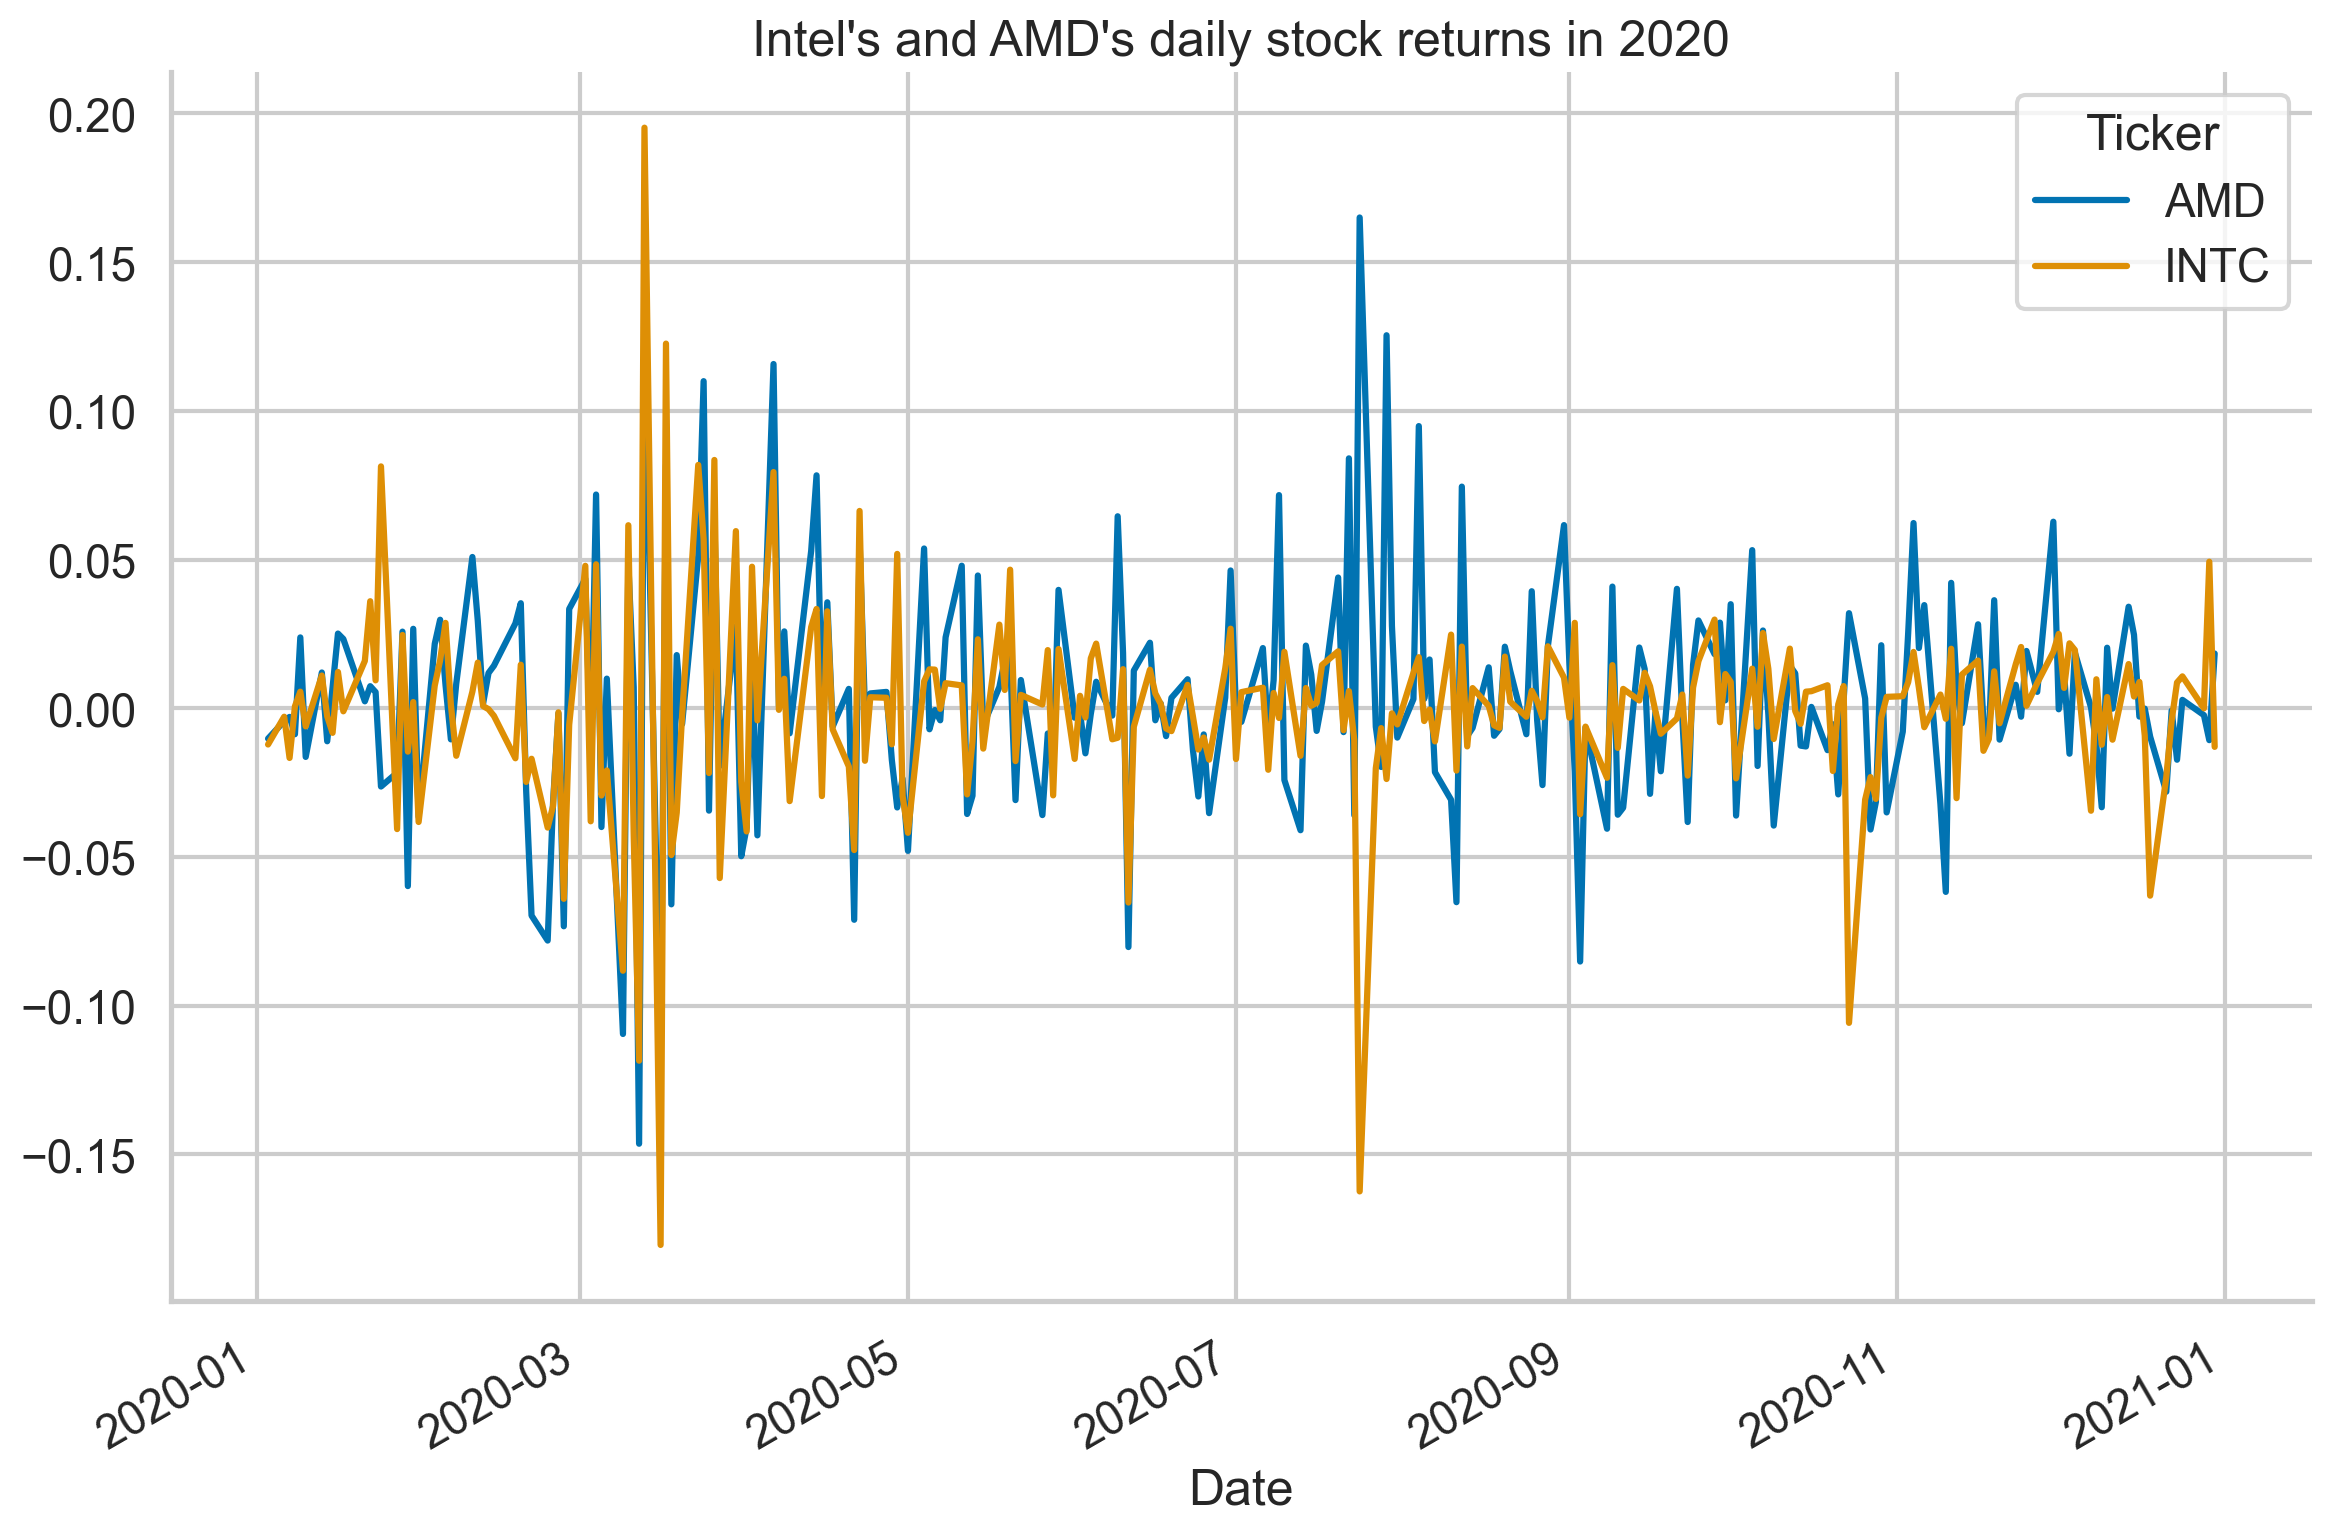

In [71]:
returns = df["Adj Close"].pct_change().dropna()
returns.plot(title="Intel's and AMD's daily stock returns in 2020")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_3", dpi=200)

In [72]:
print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

Correlation between returns: 0.50


5. Calculate the covariance matrix:

In [73]:
cov_mat = returns.cov()
cov_mat

Ticker,AMD,INTC
Ticker,,
AMD,0.001475,0.000652
INTC,0.000652,0.001137


6. Perform the Cholesky decomposition of the covariance matrix:

In [74]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.0384075 , 0.        ],
       [0.01697691, 0.02912552]])

7. Draw correlated random numbers from Standard Normal distribution:

In [75]:
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

8. Define metrics used for simulations:

In [76]:
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = df["Adj Close"].values[-1, :]
P_0 = np.sum(SHARES * S_0)

9. Calculate the terminal price of the considered stocks:

In [77]:
S_T = S_0 * np.exp(
    (r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv
)

10. Calculate the terminal portfolio value and calculate the portfolio returns:

In [78]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

11. Calculate VaR:

In [79]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f"1-day VaR with {100-x}% confidence: {-y:.2f}$")

1-day VaR with 99.99% confidence: 2.11$
1-day VaR with 99.9% confidence: 1.56$
1-day VaR with 99.0% confidence: 0.95$


12. Present the results on a graph:

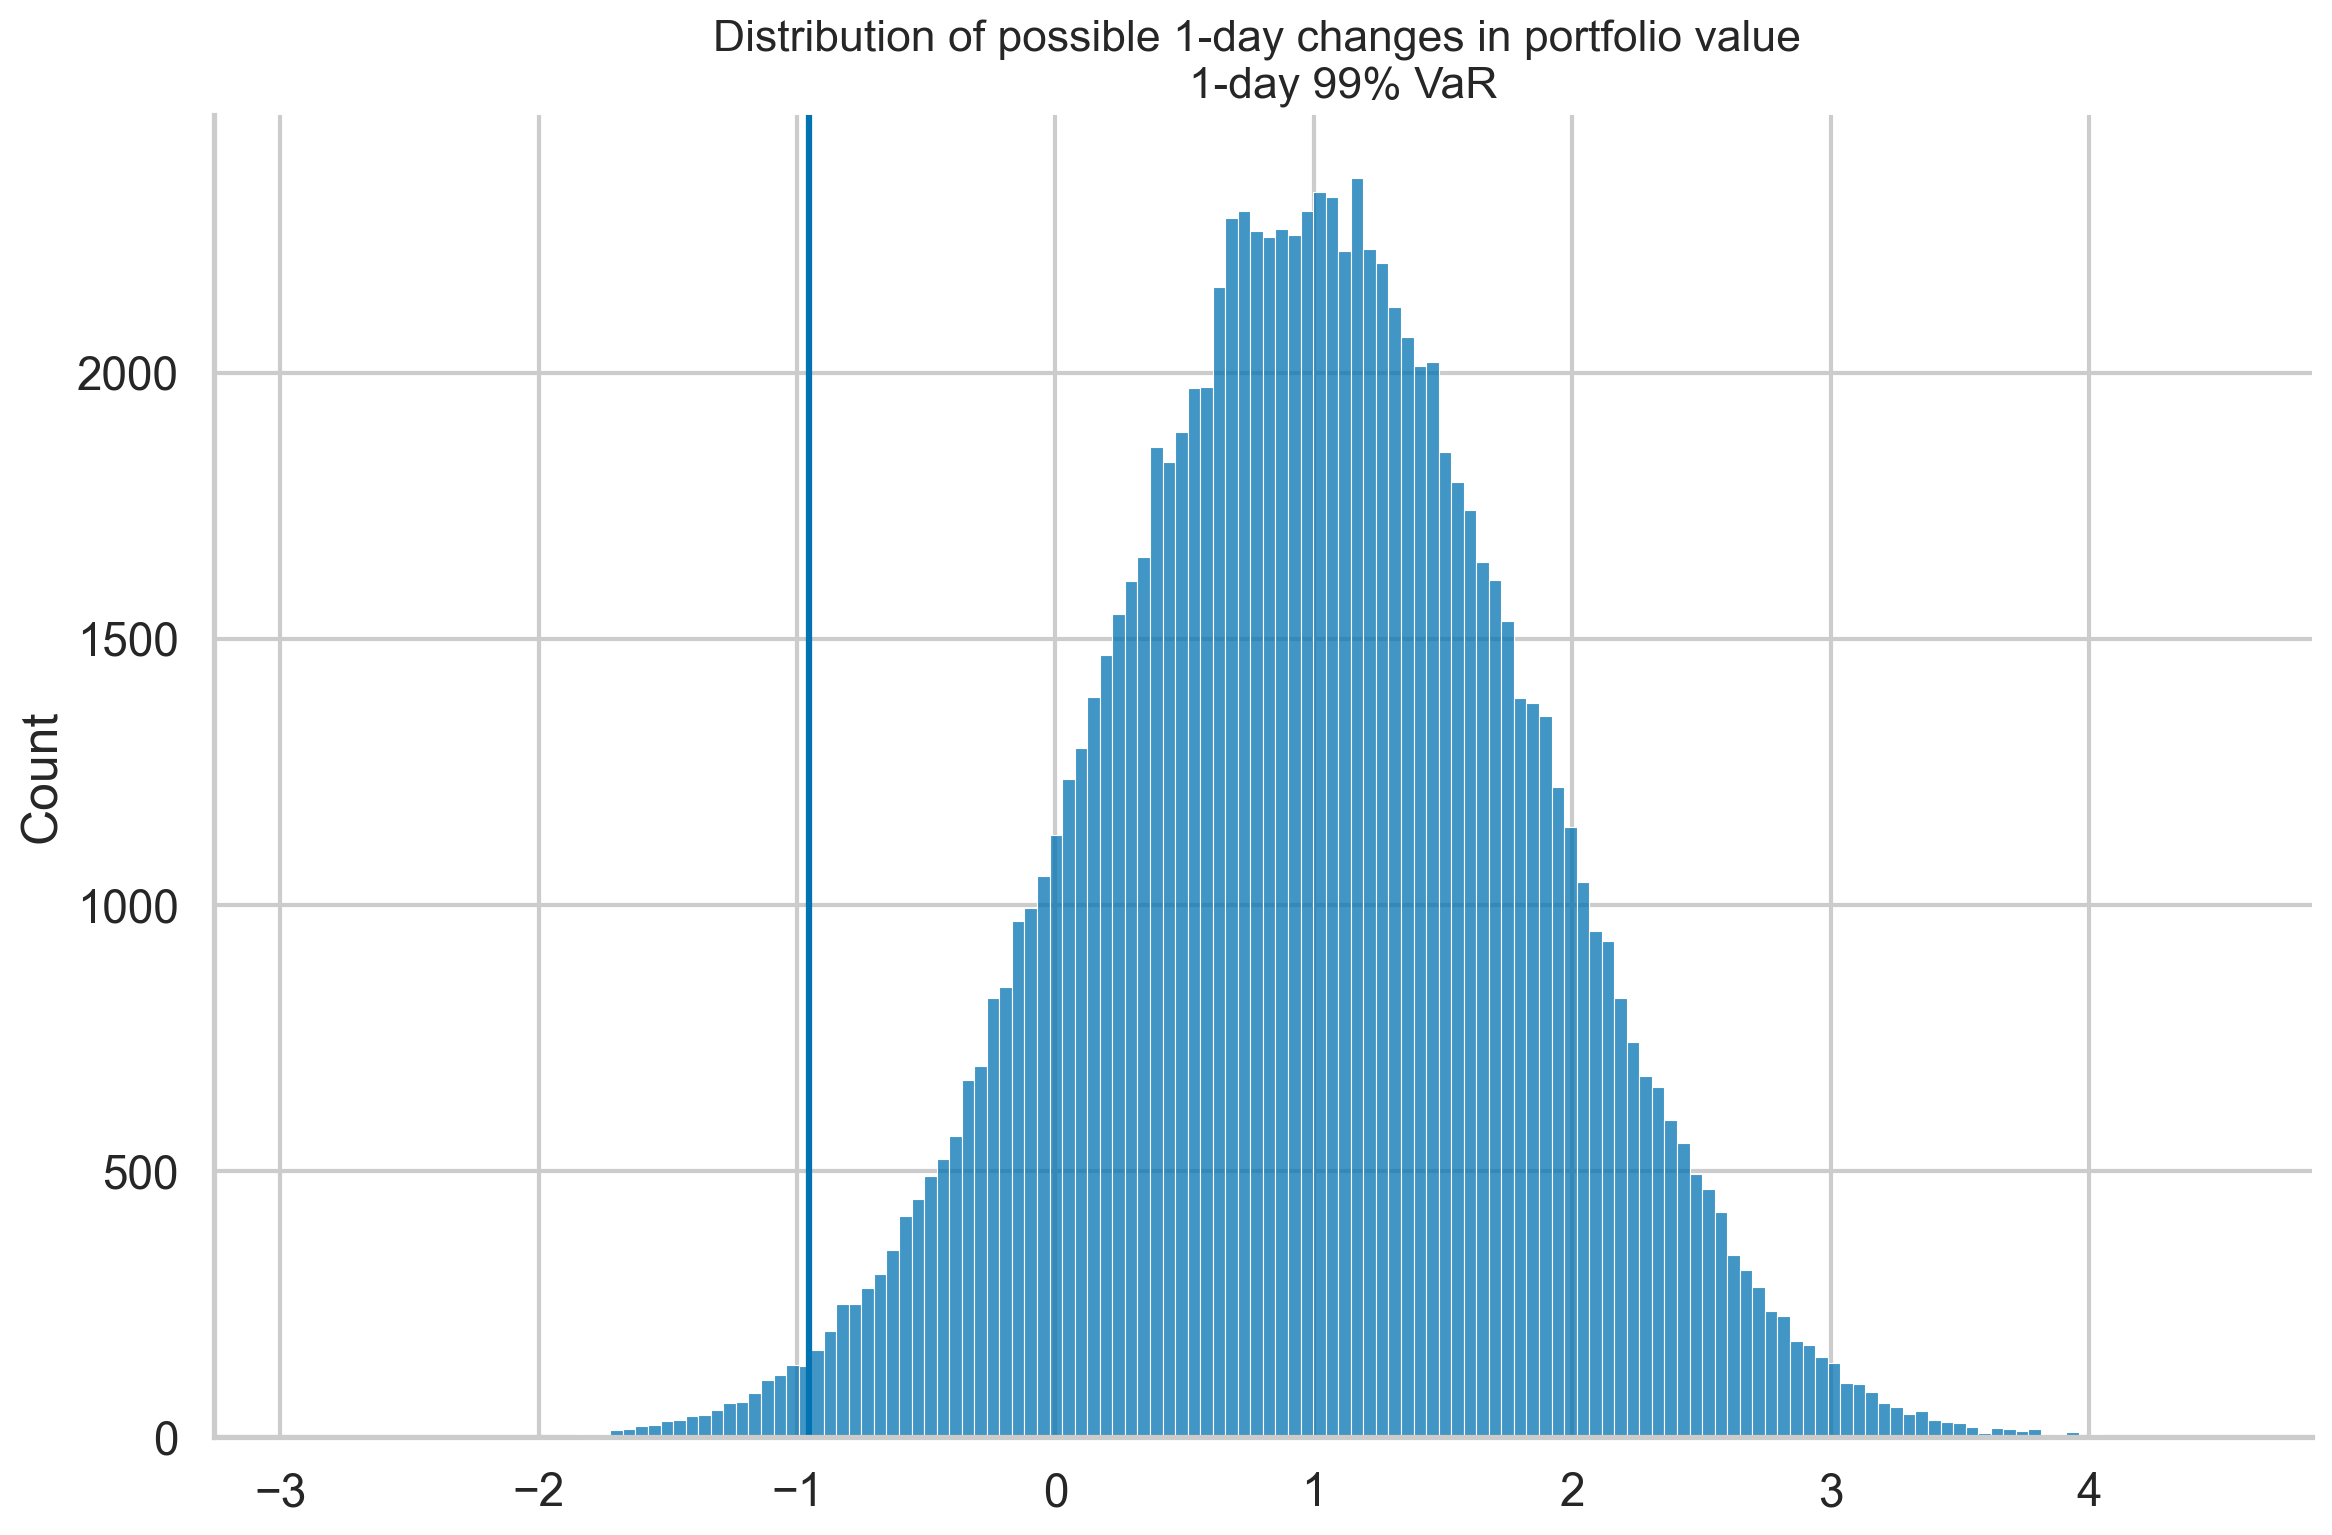

In [80]:
ax = sns.histplot(P_diff, kde=False)
ax.set_title("""Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR""", fontsize=16)
ax.axvline(var[2], 0, 10000)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_10_4", dpi=200)

### There's more

In [81]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 0.39$, and the accompanying Expected Shortfall is 0.73$.
